<a href="https://colab.research.google.com/github/FelipeBuonoEvangelista/Project-for-Study-of-Descriptive-Exploratory-and-Predictive-Analysis./blob/main/Desafio_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prevendo os usuários com alta chance de deixar um Streaming

##Objetivo:

> Utilizar um modelo de classificação para identificar e mapear o perfil de usuários com maior probabilidade de deixar a plataforma de streaming. Compreender os principais fatores que influenciam o churn é essencial para implementar estratégias eficazes de retenção de clientes, seja através de ajustes nos critérios de venda ou modificações no produto.


In [ ]:
#Instalando Bilibotecas importantes
!pip install sidetable
!pip install pandas-profiling==3.3.0
!pip install pandas

In [47]:
#Bibliotecas usadas
import numpy as np

import pandas as pd
import pandas_profiling

import seaborn as sns

import matplotlib.pyplot as plt

import requests

import sidetable

import missingno as msno

from ipywidgets import interact, widgets
from io import StringIO

import os

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import RocCurveDisplay,roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV



In [3]:
#Deixando o seaborn com um visual mais agradável
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [4]:
#função pra deixar as tabelas na mesma linha (lado a lado)
def display_side_by_side(dataframes:list,titles:list):
    html_str=''
    for df,title in zip(dataframes, titles):
        html_str+=f'<span>{title}:</span>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="&nbsp"*10
    display(HTML(html_str))

In [5]:
def list_attributes(obj):
  """Lista atributos e funções de um objeto"""
  return [attr for attr in obj.__dir__() if not attr.startswith('_')]

In [6]:
#URL do desafio
url = "https://www.notion.so/signed/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F9476d09e-5efc-4dee-8dd0-cbc871115ece%2Fstreaming_data.csv?table=block&id=35886d91-09b5-482b-8e57-582935ebf1d8&spaceId=6a055055-52ec-4ebb-a697-63027c951344&userId=c0845f00-59fb-4a0f-bb4a-c1e2314cd202&cache=v2"

# Baixar o arquivo .csv
response = requests.get(url)
data = response.text

# Ler o arquivo .csv usando o Pandas
df = pd.read_csv(StringIO(data))

#Data Understanding

##Objetivo:

> Durante esta fase, o objetivo é explorar e compreender os dados relacionados aos usuários da plataforma de streaming, identificando padrões, tendências e características que possam estar relacionadas ao churn. Isso envolve a análise descritiva dos dados, identificação de variáveis relevantes, e a preparação dos dados para a fase de modelagem, visando entender melhor o comportamento dos usuários e os possíveis motivos que levam ao churn.



##Etapas envolvidas:

1.   Carregar a base de dados;
2.   Realizar uma descrição estatística dos dados;
3.   Verificar os tipos de dados;
4.   Verificar a quantidade de valores faltantes;








In [7]:
#Visualizando os dados
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,NaN,3,NaN,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,NaN,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,NaN,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [8]:
#Fazendo uma descrição dos dados
df.describe()

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Churned
count,66607.000000,56464.000000,52696.000000,9572.000000,77884.000000,60614.000000,61148.000000
mean,43.511072,4385.848505,2.995370,2.496239,3.002273,3.002252,0.243066
std,15.043158,2526.580859,1.414072,1.120700,1.413235,1.154963,0.428938
min,18.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,30.000000,2196.000000,2.000000,1.000000,2.000000,1.990000,0.000000
50%,43.000000,4384.000000,3.000000,2.000000,3.000000,3.010000,0.000000
75%,57.000000,6573.000000,4.000000,4.000000,4.000000,4.000000,0.000000
max,69.000000,8759.000000,5.000000,4.000000,5.000000,5.000000,1.000000


#Identificando valores duplicados

In [9]:
# Identificar valores duplicados
df[df.duplicated(keep=False)]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
3,26.0,Male,NaN,5.0,Basic,NaN,2,NaN,NaN,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
7,56.0,Male,462.0,1.0,NaN,3.0,4,3.74,1.0,9ea4f106-8533-4ee2-b7b5-31691f82b72e
8,25.0,Female,3783.0,3.0,NaN,1.0,2,2.92,0.0,2c6f08fb-82be-4e3d-b40d-6aea787c3bd5
20,20.0,Male,2542.0,5.0,Basic,NaN,1,NaN,1.0,b4da071a-c8b4-44dd-84fb-7de32abf766f
21,18.0,Female,4796.0,2.0,NaN,NaN,1,NaN,1.0,2bd75dbe-2fd9-48dd-9c61-864fa08b6afe
...,...,...,...,...,...,...,...,...,...,...
77879,45.0,Male,NaN,NaN,Basic,NaN,5,2.20,0.0,6b51fe0d-d4a1-41ed-a55c-d05f5c961e3c
77880,47.0,Female,6176.0,NaN,Premium,NaN,2,4.54,0.0,59d70167-6be0-474c-b71e-14153205b44f
77881,64.0,Female,NaN,5.0,Premium,NaN,1,4.34,1.0,a7d5ed26-78a4-4e70-bd04-0fec883e56aa
77882,58.0,Male,1314.0,5.0,Standard,NaN,4,NaN,0.0,472e9e70-87ca-4c5e-bfee-fa9f42b54f51


In [10]:
# Identificar quantos valores duplicados há em cada duplicata
(
  df
 .groupby(df.columns.tolist(), dropna=False)
 .size()
 .to_frame('n_duplicates')
 .query('n_duplicates>1')
 .sort_values('n_duplicates', ascending=False)
 .head(5)
)

n_duplicates
Age  Gender Time_on_platform Devices_connected Subscription_type Num_streaming_services Num_active_profiles Avg_rating Churned User_id                                           
18.0 Female 174.0            4.0               Basic             NaN                    1                   4.91       0.0     5caf911f-7e3e-41fe-81e8-b92c1486d511             2
58.0 Female 7680.0           2.0               NaN               NaN                    5                   NaN        0.0     43891e92-ae54-45ac-b180-52d9563b29fc             2
            NaN              NaN               Premium           NaN                    2                   2.82       0.0     3be60fd4-f7a7-4f6a-ab97-fd53f8c7e565             2
                                               Standard          NaN                    1                   1.35       NaN     dd987b62-33cc-44bb-8b2c-102dee37def3             2
                                                                                        2                   NaN        NaN     1f7035d1-82b2-4b9d-ab05-259b04d0b264             2

In [11]:
# Remover valores duplicados
df = df.drop_duplicates()

In [12]:
#Provando que não há valores Duplicados
df[df.duplicated(keep=False)]

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id


#Identificando Nulos

In [13]:
# Identificar e mostrar valores nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
Num_streaming_services,57392,87.65%
Devices_connected,21185,32.35%
Subscription_type,21180,32.35%
Time_on_platform,17965,27.44%
Avg_rating,14501,22.15%
Churned,14105,21.54%
Gender,12164,18.58%
Age,9508,14.52%
Num_active_profiles,0,0.00%
User_id,0,0.00%


#Verificando o tipo dos Dados

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65481 entries, 0 to 65480
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     55973 non-null  float64
 1   Gender                  53317 non-null  object 
 2   Time_on_platform        47516 non-null  float64
 3   Devices_connected       44296 non-null  float64
 4   Subscription_type       44301 non-null  object 
 5   Num_streaming_services  8089 non-null   float64
 6   Num_active_profiles     65481 non-null  int64  
 7   Avg_rating              50980 non-null  float64
 8   Churned                 51376 non-null  float64
 9   User_id                 65481 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 5.5+ MB


#Data Preparation

##Objetivo:


> O objetivo do Data Preparation para o desafio de mapear o perfil de usuários com maior probabilidade de deixar a plataforma de streaming é garantir que os dados estejam prontos e adequados para a modelagem de classificação. Isso envolve o tratamento de valores ausentes, a transformação de dados categóricos em formatos numéricos, a seleção de variáveis relevantes, o balanceamento de classes, a normalização ou padronização de variáveis numéricas, a criação de novas variáveis informativas e a divisão do conjunto de dados em conjuntos de treinamento, validação e teste. O objetivo final é preparar os dados de forma que possam ser utilizados de maneira eficaz na construção de um modelo preditivo de churn.

##Etapas:

1.   Substituir valores “NaN” por 0 Colunas → Time_on_platform,
Num_streaming_services, Churned, Avg_rating, Devices_connected
2.   Dropar linhas nulas nas colunas Gender, Subscription_type e Age
3.   Transformar valores churned 0 e 1 por No e Yes
4.   Transformar valores floats em valores inteiros



In [15]:
# 1.Substituir valores “NaN” por 0 Colunas → Time_on_platform, Num_streaming_services, Churned, Avg_rating, Devices_connected
cols_fill = ['Time_on_platform', 'Num_streaming_services', 'Churned', 'Avg_rating', 'Devices_connected']
df[cols_fill] = df[cols_fill].fillna(0)
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
4,18.0,NaN,1948.0,3.0,Basic,0.0,3,3.88,0.0,14879bcb-1977-4ad8-a7f9-6aa9bf7b872f


In [16]:
#Dropar linhas nulas nas colunas Gender, Subscription_type e Age
colscheck = ['Gender', 'Subscription_type', 'Age']
df.dropna(subset=colscheck, inplace=True)

In [17]:
#Verificando os nulos
df_missing = (
  df.isna().sum()
  .to_frame('missing_count')
  .join((df.isna().sum() / df.shape[0]).to_frame('missing_pct'))
  .sort_values('missing_count', ascending=False)
)

df_missing.style.format('{:.2%}', subset=['missing_pct'])

,missing_count,missing_pct
Age,0,0.00%
Gender,0,0.00%
Time_on_platform,0,0.00%
Devices_connected,0,0.00%
Subscription_type,0,0.00%
Num_streaming_services,0,0.00%
Num_active_profiles,0,0.00%
Avg_rating,0,0.00%
Churned,0,0.00%
User_id,0,0.00%


In [18]:
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,0.0,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,0.0,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,1.0,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26.0,Male,0.0,5.0,Basic,0.0,2,0.00,0.0,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54.0,Male,3024.0,2.0,Basic,0.0,1,0.00,0.0,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [19]:
#3.Transformar valores churned 0 e 1 por No e Yes
df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})
df.head(3)

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49.0,Male,4700.0,3.0,Basic,0.0,3,0.00,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69.0,Female,6107.0,2.0,Standard,0.0,1,2.14,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44.0,Male,6374.0,3.0,Premium,1.0,1,1.91,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d


In [20]:
#4.Transformar valores floats em valores inteiros
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30739 entries, 0 to 65479
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     30739 non-null  float64
 1   Gender                  30739 non-null  object 
 2   Time_on_platform        30739 non-null  float64
 3   Devices_connected       30739 non-null  float64
 4   Subscription_type       30739 non-null  object 
 5   Num_streaming_services  30739 non-null  float64
 6   Num_active_profiles     30739 non-null  int64  
 7   Avg_rating              30739 non-null  float64
 8   Churned                 30739 non-null  object 
 9   User_id                 30739 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 2.6+ MB


In [21]:
df[['Age','Time_on_platform','Devices_connected','Num_streaming_services','Avg_rating']] = df[['Age','Time_on_platform','Devices_connected','Num_streaming_services','Avg_rating']].astype(int)
df.info()
df.head(4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30739 entries, 0 to 65479
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     30739 non-null  int64 
 1   Gender                  30739 non-null  object
 2   Time_on_platform        30739 non-null  int64 
 3   Devices_connected       30739 non-null  int64 
 4   Subscription_type       30739 non-null  object
 5   Num_streaming_services  30739 non-null  int64 
 6   Num_active_profiles     30739 non-null  int64 
 7   Avg_rating              30739 non-null  int64 
 8   Churned                 30739 non-null  object
 9   User_id                 30739 non-null  object
dtypes: int64(6), object(4)
memory usage: 2.6+ MB


,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2


#Modelagem dos Dados - Regressão Logística

##Objetivo:

> O objetivo de utilizar a regressão logística nesse contexto é construir um modelo que possa prever a probabilidade de um usuário churnar (ou seja, deixar a plataforma) com base em diversas variáveis explicativas, como tempo de uso, número de serviços de streaming utilizados, idade, entre outras.


> A regressão logística é adequada para esse problema porque permite modelar a relação entre variáveis explicativas contínuas ou categóricas e uma variável dependente binária (churned ou não churned). Além disso, a regressão logística fornece uma interpretação direta dos coeficientes, o que permite entender como cada variável está relacionada à probabilidade de churn.

> Em resumo, o objetivo de utilizar a regressão logística é criar um modelo que possa prever de forma eficaz e interpretable a probabilidade de um usuário churnar com base em características específicas, auxiliando assim na identificação de estratégias para retenção de clientes e redução do churn.

##Etapas:

1.   Definir variáveis X e y para o modelo
2.   Realizar o .fit do modelo
3.   Separar em train e test
4.   Realizar a modelagem
5.   Plotar matrix confusão
6.   Printar métricas



In [22]:
df.head()

,Age,Gender,Time_on_platform,Devices_connected,Subscription_type,Num_streaming_services,Num_active_profiles,Avg_rating,Churned,User_id
0,49,Male,4700,3,Basic,0,3,0,No,a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1,69,Female,6107,2,Standard,0,1,2,No,fe14b048-770b-4619-8ec6-485b0969ae31
2,44,Male,6374,3,Premium,1,1,1,Yes,0283dffd-6684-4a05-9c6f-c02098a6849d
3,26,Male,0,5,Basic,0,2,0,No,c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5,54,Male,3024,2,Basic,0,1,0,No,a1df3a13-9255-4d00-8a9d-20565fefaab9


In [23]:
cat_vars = ['Gender',"Subscription_type"]
num_vars = ['Age',"Time_on_platform","Devices_connected","Num_streaming_services","Num_active_profiles","Avg_rating"]
modeling_vars = cat_vars + num_vars

In [24]:
X = df.filter(modeling_vars).copy()
y = df['Churned'].copy()
y = pd.DataFrame(y)

In [25]:
le = LabelEncoder()

le.fit(y.Churned)
y.Churned = le.transform(y.Churned)

In [26]:
X = pd.get_dummies(X)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [28]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
model = LogisticRegression()
lr = model.fit(X_train_scaled, y_train)
accuracy = model.score(X_test_scaled, y_test)
print(f'Acurácia do modelo: {accuracy}')

Acurácia do modelo: 0.8059531554977228


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
lr.predict(X_test_scaled)

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
X_test.assign(churn = y_test).assign(label = lr.predict(X_test_scaled))

,Age,Time_on_platform,Devices_connected,Num_streaming_services,Num_active_profiles,Avg_rating,Gender_Female,Gender_Male,Subscription_type_Basic,Subscription_type_Premium,Subscription_type_Standard,churn,label
9902,32,2775,0,0,2,2,1,0,0,1,0,1,0
31869,40,4623,3,3,5,1,1,0,0,0,1,0,0
64186,66,0,2,0,3,1,0,1,1,0,0,0,0
43333,59,1752,0,0,2,1,1,0,1,0,0,0,0
25684,46,1070,3,0,5,1,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24544,38,1327,1,1,4,3,1,0,0,1,0,1,0
64339,36,1519,0,0,2,1,0,1,0,0,1,1,0
64950,25,3674,4,0,5,0,0,1,0,0,1,1,0
16036,53,2799,1,0,5,0,0,1,0,1,0,0,0


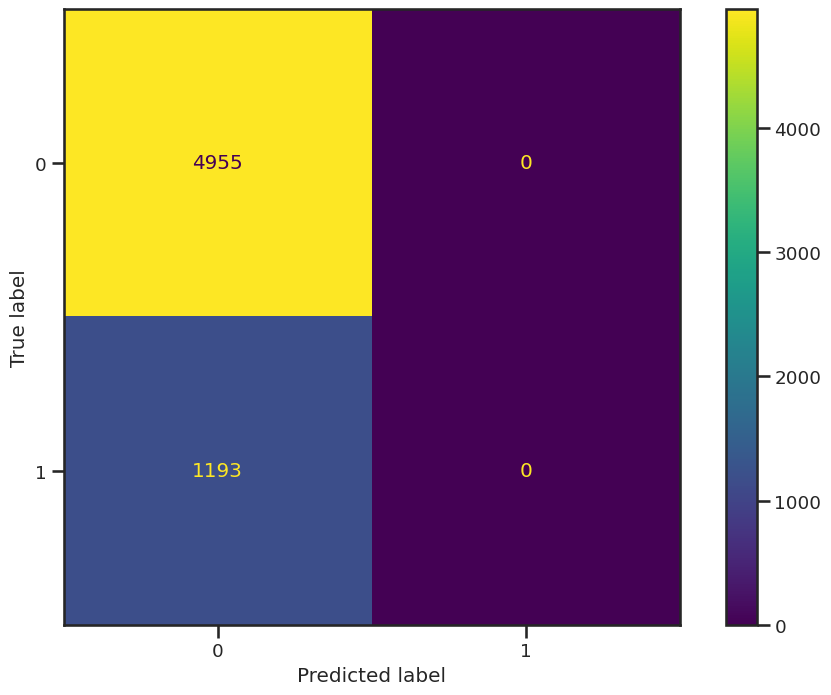

In [38]:
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [39]:
model = LogisticRegression()
lr = model.fit(X_train_scaled, y_train)
accuracy = model.score(X_test_scaled, y_test)
print(f'Acurácia do modelo: {accuracy}')

Acurácia do modelo: 0.8059531554977228


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
#Printando méricas

print(f"Acurácia (Treino): {accuracy_score(y_train, lr.predict(X_train_scaled))}")
print(f"Acurácia (Teste): {accuracy_score(y_test, lr.predict(X_test_scaled))}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, lr.predict(X_train_scaled))}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, lr.predict(X_test_scaled))}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, lr.predict(X_train_scaled))}")
print(f"Precision (Teste): {precision_score(y_test, lr.predict(X_test_scaled))}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, lr.predict(X_train_scaled))}")
print(f"Recall (Teste): {recall_score(y_test, lr.predict(X_test_scaled))}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, lr.predict(X_train_scaled))}")
print(f"F1-Score (Teste): {f1_score(y_test, lr.predict(X_test_scaled))}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, lr.predict_proba(X_train_scaled)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1])}")

Acurácia (Treino): 0.8059452645276727
Acurácia (Teste): 0.8059531554977228
Acurácia Balanceada (Treino): 0.5
Acurácia Balanceada (Teste): 0.5
Precision (Treino): 0.0
Precision (Teste): 0.0
Recall (Treino): 0.0
Recall (Teste): 0.0
F1-Score (Treino): 0.0
F1-Score (Teste): 0.0
ROCAUC (Treino): 0.5138701708974179
ROCAUC (Teste): 0.49265696380585366


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Modelagem dos Dados - Tunning

##Objetivo:

> Para o desafio de mapear o perfil de usuários com maior probabilidade de deixar a plataforma de streaming, o tuning de hiperparâmetros pode ser utilizado para encontrar a melhor combinação de hiperparâmetros para o modelo de regressão logística. Isso pode incluir, por exemplo, o ajuste da regularização, o tipo de solver a ser usado, o número máximo de iterações, entre outros.


> O objetivo do tuning de hiperparâmetros neste contexto é melhorar a capacidade do modelo de generalizar para novos dados, aumentando assim a sua precisão na previsão do churn. Ao ajustar os hiperparâmetros de forma adequada, é possível obter um modelo mais eficiente e preciso, contribuindo para a redução do churn e a melhoria da retenção de clientes na plataforma de streaming.

##Etapas:

1.   Realizar o .fit do modelo
2.   Separar em train e test
3.   Realizar a modelagem
4.   Plotar matrix confusão
5.   Printar métricas


In [46]:
arvore_decisao = DecisionTreeClassifier()

In [48]:
parameters = {
  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

In [50]:
grid_search = GridSearchCV(arvore_decisao, parameters, scoring='roc_auc', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

In [51]:
# criando uma tabela com os resultados do grid_search
results = pd.DataFrame(grid_search.cv_results_)

# rankeando esses resultados
results.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.078356,0.002878,0.013174,0.000551,9,{'max_depth': 9},0.494568,0.512776,0.504531,0.511246,0.509063,0.506437,0.006553,1
7,0.071953,0.002713,0.013108,0.000402,8,{'max_depth': 8},0.501685,0.504714,0.493146,0.500519,0.508637,0.501740,0.005133,2
9,0.085118,0.001379,0.012373,0.001950,10,{'max_depth': 10},0.478736,0.510423,0.503170,0.514261,0.496960,0.500710,0.012498,3
0,0.038485,0.007144,0.026193,0.004623,1,{'max_depth': 1},0.498403,0.501631,0.500534,0.499835,0.499294,0.499939,0.001096,4
1,0.045531,0.013511,0.026146,0.006380,2,{'max_depth': 2},0.496806,0.502010,0.496072,0.503277,0.493085,0.498250,0.003819,5
6,0.070959,0.008342,0.013596,0.001746,7,{'max_depth': 7},0.493304,0.497937,0.495415,0.501756,0.501747,0.498032,0.003373,6
5,0.061647,0.003012,0.014915,0.001268,6,{'max_depth': 6},0.489090,0.492259,0.497789,0.501811,0.500565,0.496303,0.004880,7
3,0.071993,0.021436,0.016931,0.005716,4,{'max_depth': 4},0.496089,0.505507,0.486952,0.500029,0.489926,0.495701,0.006707,8
2,0.063313,0.017333,0.024063,0.008209,3,{'max_depth': 3},0.483967,0.496039,0.493004,0.511721,0.492426,0.495431,0.009078,9
4,0.053870,0.003861,0.014380,0.001097,5,{'max_depth': 5},0.482392,0.500049,0.494338,0.502589,0.491387,0.494151,0.007098,10


In [53]:
#Encontrando o melhor Parâmetro
grid_search.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [57]:

y_pred_grid = grid_search.predict(X_test)
best_model = grid_search.best_estimator_
y_train_pred_grid = best_model.predict(X_train)
y_test_pred_grid = best_model.predict(X_test)

In [61]:
#Printando méricas

print(f"Acurácia (Treino): {accuracy_score(y_train, y_train_pred_grid)}")
print(f"Acurácia (Teste): {accuracy_score(y_test, y_test_pred_grid)}")
print("====================================")
print(f"Acurácia Balanceada (Treino): {balanced_accuracy_score(y_train, y_train_pred_grid)}")
print(f"Acurácia Balanceada (Teste): {balanced_accuracy_score(y_test, y_test_pred_grid)}")
print("====================================")
print(f"Precision (Treino): {precision_score(y_train, y_train_pred_grid)}")
print(f"Precision (Teste): {precision_score(y_test, y_test_pred_grid)}")
print("====================================")
print(f"Recall (Treino): {recall_score(y_train, y_train_pred_grid)}")
print(f"Recall (Teste): {recall_score(y_test, y_test_pred_grid)}")
print("====================================")
print(f"F1-Score (Treino): {f1_score(y_train, y_train_pred_grid)}")
print(f"F1-Score (Teste): {f1_score(y_test, y_test_pred_grid)}")
print("====================================")
print(f"ROCAUC (Treino): {roc_auc_score(y_train, best_model.predict_proba(X_train)[:,1])}")
print(f"ROCAUC (Teste): {roc_auc_score(y_test, best_model.predict_proba(X_test)[:,1])}")

Acurácia (Treino): 0.8100931235004677
Acurácia (Teste): 0.8004229017566689
Acurácia Balanceada (Treino): 0.5142670727925107
Acurácia Balanceada (Teste): 0.5007057651300937
Precision (Treino): 0.765625
Precision (Teste): 0.21666666666666667
Recall (Treino): 0.03080469404861693
Recall (Teste): 0.010896898575020955
F1-Score (Treino): 0.05922643029814665
F1-Score (Teste): 0.02075019952114924
ROCAUC (Treino): 0.5914673700171802
ROCAUC (Teste): 0.5021528204807221


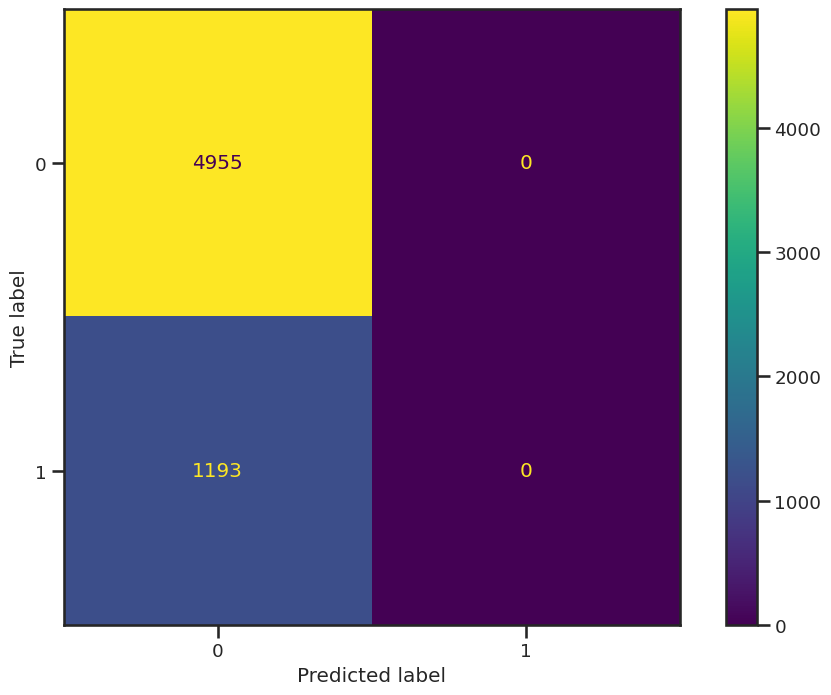

In [62]:
#Gráfico de confusão
cm_grif = confusion_matrix(y_test, y_test_pred_grid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot()
plt.show()

#Modelagem dos Dados - Random Forest
##Objetivo:

> No contexto do desafio de mapear o perfil de usuários com maior probabilidade de deixar a plataforma de streaming, o objetivo de usar o algoritmo Random Forest é construir um modelo de classificação robusto e preciso. O Random Forest é uma técnica de ensemble learning que combina várias árvores de decisão para melhorar a precisão e a estabilidade do modelo.

> Ao usar o Random Forest, o objetivo é explorar a complexidade dos dados e identificar padrões não lineares que possam influenciar o churn dos usuários. O algoritmo é capaz de lidar com uma grande quantidade de variáveis explicativas e de capturar interações complexas entre essas variáveis, o que pode ser útil para identificar os principais fatores que contribuem para o churn.

> Além disso, o Random Forest é menos sensível a overfitting do que uma única árvore de decisão, pois combina múltiplas árvores e reduz a variância do modelo. Isso ajuda a garantir que o modelo seja mais generalizável e tenha um bom desempenho em dados não vistos.

> Em resumo, o objetivo de usar o Random Forest neste desafio é construir um modelo de classificação robusto e preciso que possa identificar os usuários com maior probabilidade de churn, auxiliando assim na implementação de estratégias eficazes de retenção de clientes.
##Etapas:

1.   Realizar a montagem do grid search
2.   Realizar o .fit do modelo
3.   Realizar o Tunning
4.   Realizar a modelagem
5.   Plotar matrix confusão
6.   Printar métricas


